<a href="https://colab.research.google.com/github/murtazav/Model_predictive_control/blob/master/Parameter_finder_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# best controller parameterfinder using genetic algorithm
import numpy as np
import random
from matplotlib import pyplot as plt

population = 20
kp_arr = np.zeros(population)
ki_arr = np.zeros(population)
fit_arr = np.zeros(population)
kp_max = 100.0
kp_min = 0.0
ki_max = 100.0
ki_min = 0.0
itr = 50



In [0]:
#environment with bicycle model which returns fitness of a controller
def envm(kp, ki):
  mfl=158  # mass at front left wheel
  mfr=137  # mass at front right wheel
  mrl=360  # mass at rear left wheel
  mrr=269  # mass at front right wh

  m = 924  #mass of the vehicle

  lf= 1.31  # location of centre of gravity from the front axle
  lr=0.62   # location of centre of gravity from the rear axle
  Iz=748    # moment of inertia
  l=lf+lr

  V=1
  #cornering stiffness of tyre
  Cf=27359
  Cr=58535
  dt=0.001
  tf=10
  vy = np.zeros(15000)
  vy_dot = np.zeros(15000)
  delt_4 = np.zeros(15000) 
  theta_dot = np.zeros(15000)
  theta_4 = np.zeros(15000)
  theta_des = np.zeros(15000)
  theta_ddot = np.zeros(15000)
  e = np.zeros(15000)
  e_int = np.zeros(15000)
  fitness =0
  time = np.zeros(15000)
  for i in range(1,len(time)):
    time[i] = time[i-1]+dt
  i=1
  for t in time[0:10000]:
    if i>=1000:
      theta_des[i]=0.349

    e[i] = (theta_des[i]-theta_4[i-1])
    fitness = fitness - np.power(t,2)*np.absolute(e[i])*dt
    e_int[i] = e_int[i-1]+e[i]*0.001
    delt_4[i]=kp*e[i]+ki*e_int[i]

    vy_dot[i]=-V*theta_dot[i-1]+1/m*(Cr*(-np.arctan((vy[i-1]-lr*theta_dot[i-1])/V))+Cf*(delt_4[i]-np.arctan((vy[i-1]+lf*theta_dot[i-1])/V))*np.cos(delt_4[i]))
    theta_ddot[i]=1/Iz*(Cr*lr*(-np.arctan((vy[i-1]-lr*theta_dot[i-1])/V))+Cf*(delt_4[i]-np.arctan((vy[i-1]+lf*theta_dot[i-1])/V))*np.cos(delt_4[i])*lf)

    theta_dot[i] = theta_ddot[i]*dt +theta_dot[i-1]
    theta_4[i] = theta_dot[i]*dt+theta_4[i-1]
    vy[i] = vy_dot[i]*dt+vy[i-1]
    i = i+1 
    #print(fitness)
  plt.plot(time[0:10000],theta_4[0:10000]*180/np.pi)
  plt.plot(time[0:10000],theta_des[0:10000]*180/np.pi)
  
  plt.plot(time[0:10000],delt_4[0:10000]*180/np.pi)
  plt.legend(['heading_angle','desired heading','steering angle'])
  plt.xlabel('time in s')
  plt.ylabel('Angle in degrees')
  # linearly penalizing max steering angle, max overshoot, randomly improving fitness with mean 5 and std 5 to introduce luck in evolution process
  fitness = 10*fitness - 40*np.amax(delt_4[0:10000]) -100*(np.amax(theta_4[0:10000])-np.amax(theta_des[0:10000])) + (np.random.randn()*5+5)
  return fitness



-55.49449446365769

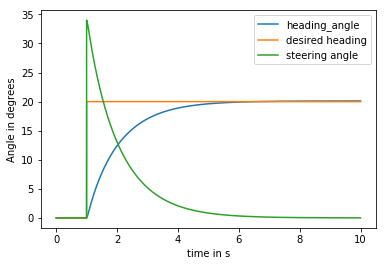

In [11]:
envm(1.7,0.01)

In [0]:
# to randomly generate a contorller within the range
def random_birth(kp_arr, ki_arr):
  for i in range(population):
    kp_arr[i] = random.uniform(kp_min, kp_max)
    ki_arr[i]= random.uniform(ki_max, kp_min)
  return kp_arr, ki_arr

# to generate offspring from the best parents with added mutation
def offspring(kp_mean, kp_std, ki_mean, ki_std):
  kp = np.absolute(np.random.randn()*kp_mean +kp_std)
  ki = np.absolute(np.random.randn()*ki_mean + ki_std)

  #mutation 
  if random.random() < 0.1 :
    kp = np.absolute(kp + 0.1*(np.random.randn()*kp_mean+kp_std))
    ki = np.absolute(ki + 0.1*(np.random.randn()*ki_mean+ki_std))
  return kp, ki
	



In [0]:
# to iteratively create and delete generations to reach the generaton with best fitness score
def iterations(kp_arr, ki_arr, fit_arr):
  for i in range(itr):
    for j in range(population):
      fit_arr[j] = envm(kp_arr[j], ki_arr[j])

    # sort remove the half controllers with worst fitness
    sorted_index = np.argsort(fit_arr)
    kp_arr = kp_arr[sorted_index]
    ki_arr = ki_arr[sorted_index]
    fit_arr = fit_arr[sorted_index]
    print(str(kp_arr[-1])+'  '+str(ki_arr[-1])+'  '+str(fit_arr[-1]))
    # generate offsprings with the best four controllers

    kp_mean = np.average(kp_arr[int(population/2):population])
    kp_std = np.std(kp_arr[int(population/2):population])
    ki_mean = np.average(ki_arr[int(population/2):population])
    ki_std = np.std(ki_arr[int(population/2):population])
    for j in range(int(population/2)):
      kp_arr[j], ki_arr[j] = offspring(kp_mean, kp_std, ki_mean, ki_std)
   
  return kp_arr, ki_arr, fit_arr

In [14]:
a=np.array([1,33,455,67,0,8])
a[np.argsort(a)]

array([  0,   1,   8,  33,  67, 455])

In [0]:
kp_arr, ki_arr = random_birth(kp_arr, ki_arr)


16.365262823749006  34.08219321566949  -260.58491027899004
16.365262823749006  34.08219321566949  -262.0203723575861
15.70982477378438  29.075282041721103  -255.06164210747292
15.70982477378438  29.075282041721103  -248.5221153401626
1.465612009718452  5.096211946993925  -111.8067033788896
2.8503255459403256  7.286659360771452  -63.4943796167172
2.8503255459403256  7.286659360771452  -64.3168104829739
2.8503255459403256  7.286659360771452  -55.72155537440861
2.8503255459403256  7.286659360771452  -76.41839682451355
3.9112276900290963  2.2301214708506736  -67.82998162412387
2.8503255459403256  7.286659360771452  -66.19493957026805
2.290974143229009  5.220481196652406  -56.22590342330444
3.2403607654385755  4.292568812562178  -56.87539950213135
3.2403607654385755  4.292568812562178  -62.19403140503956
2.129284973955293  0.05251533506364625  -51.99336846204028
3.2403607654385755  4.292568812562178  -51.22689549228175
3.218342647064244  0.12807279747183564  -54.17797806704682
2.56061453853

(array([1.97775716, 3.34733921, 1.55127528, 1.38349995, 1.71563634,
        1.9935659 , 2.52466773, 1.12264411, 1.66911625, 4.7778904 ,
        2.82513158, 1.95648708, 2.79372311, 3.86768394, 3.14017408,
        1.72286738, 2.13301434, 2.98061615, 2.12928497, 2.15471759]),
 array([2.50046352, 0.97602988, 2.99606363, 2.17480606, 0.21248545,
        3.10687312, 2.16186447, 0.88163331, 3.0822941 , 3.01780673,
        2.22287697, 0.06354462, 2.48414632, 0.0711804 , 4.79039098,
        0.03302779, 0.05224987, 0.06696053, 0.05251534, 0.02178558]),
 array([-1.44449595e+06, -3.85321141e+02, -1.66649172e+02, -1.03243708e+02,
        -9.76992283e+01, -8.85891290e+01, -8.23627917e+01, -7.84755007e+01,
        -7.15550480e+01, -6.63333553e+01, -6.61207767e+01, -6.21273535e+01,
        -6.18879864e+01, -5.96201530e+01, -5.61048847e+01, -5.41614737e+01,
        -5.21094446e+01, -4.72310032e+01, -4.45688075e+01, -4.09716009e+01]))

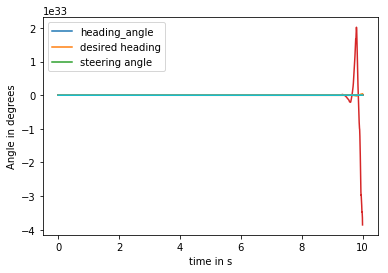

In [20]:
iterations(kp_arr, ki_arr, fit_arr)

-39.355184213602094

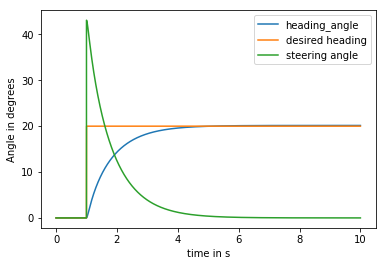

In [21]:
envm(2.15471759,0.02178)


-54.635440989022875

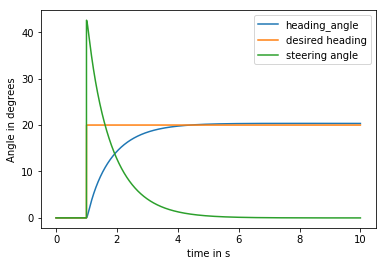

In [22]:
envm(2.12928497,0.05251534)


-58.71362978598469

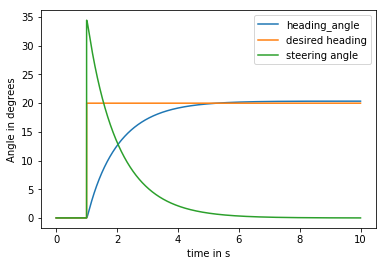

In [23]:
envm(1.72286738,0.03302779)